## API Keys

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

## LLM

In [2]:
local_llm = "llama3"
model_tested = "llama3-8b"
metadata = f"CRAG, {model_tested}"

## Creating Index

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_openai import OpenAIEmbeddings

import warnings
warnings.filterwarnings('ignore')

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Loading documents from URL and saving to list
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initializing Text splitter with chunksize and chunk overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Splitting Documents to chunks
doc_splits = text_splitter.split_documents(docs_list)

# Creating Embedding
embedding = NomicEmbeddings(
    model="nomic-embed-text-v1.5",
    inference_mode="local"
)

# Creating vectorstore using splitted documents
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Embedding texts: 100%|██████████| 194/194 [02:06<00:00,  1.53inputs/s]


## Defining Tools

#### Retrieval Grader

In [4]:
from langchain_core.prompts import PromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain_core.output_parsers import JsonOutputParser


llm = OllamaLLM(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"]
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "How does the ReAct agent use self-reflection?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 22.99inputs/s]


{'score': 1}


#### Answer Generator

In [24]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"]
)

# llm = OllamaLLM(model=local_llm, temperature=0)
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"documents": docs, "question": question})

print(generation)

The ReAct agent uses self-reflection to iteratively improve its performance by analyzing past actions and correcting mistakes. This process involves self-criticism and refinement, which enhances the quality of future results. By integrating reasoning with acting, ReAct can generate reasoning traces that inform its decision-making.


#### Searcher

In [25]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

## Creating Graph using Langgraph

In [26]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

class GraphState(TypedDict):
    
	question: str
	generation: str
	search: str
	documents: List[str]
	steps: List[str]

In [27]:
def retrieve(state):
    question = state['question']
    documents = retriever.invoke(question)
    steps = state['steps']
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}

In [28]:
def grade_documents(state):
	question= state["question"]
	documents = state["documents"]
	steps = state["steps"]
	steps.append("grade_document_retrieval")
	filtered_docs = []
	search = "No"
	
	for d in documents:
		score = retrieval_grader.invoke({"question": question, "documents": d.page_content})
		grade = score["score"]
		if grade == 1:
			filtered_docs.append(d)
		elif grade == 0:
			search = "Yes"
			continue
	return {
		"documents": filtered_docs,
		"question": question,
		"search": search,
		"steps": steps
	}

In [29]:
def decide_to_generate(state):
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

In [30]:
def web_search(state):
	question = state["question"]
	documents = state["documents"]
	steps = state["steps"]
	steps.append("web_search")
	web_results = web_search_tool.invoke({"query": "question"})
	documents.extend(
		[Document(page_content=d["content"], metadata={"url": d["url"]}) for d in web_results]
		)
	return {"documents": documents, "question": question, "steps": steps}

In [31]:
def generate(state):
	question = state["question"]
	documents = state["documents"]
	generation = rag_chain.invoke({"documents": documents, "question": question})
	steps = state["steps"]
	steps.append("generate_answer")
	
	return {
		"documents": documents,
		"question": question,
		"generation": generation,
		"steps": steps
	}

#### Creating Graph

In [32]:
# Graph
workflow = StateGraph(GraphState)

# Adding Nodes
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('web_search', web_search)

# Build Graph
workflow.add_edge(START, 'retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents', 
    decide_to_generate,
    {
        'search': 'web_search',
        'generate': 'generate'
	}
)
workflow.add_edge('web_search', 'generate')
workflow.add_edge('generate', END)
custom_graph = workflow.compile()

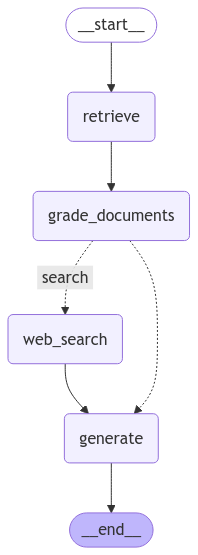

In [33]:
display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [34]:
import uuid

def get_agent_answer(qn: dict):
	config = {"configurable": {"thread_id": str(uuid.uuid4())}}
	state_dict = custom_graph.invoke({"question": qn["input"], "steps": []}, config)
	return {"response": state_dict["generation"], "steps": state_dict["steps"]}

qn = {"input": "What are the types of agent memory?"}
response = get_agent_answer(qn)
response

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 22.15inputs/s]


{'response': 'The types of agent memory include short-term memory and long-term memory. Short-term memory is utilized for in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. Additionally, sensory memory is mentioned as an early stage that retains impressions of sensory information.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

In [35]:
print(response['response'])

The types of agent memory include short-term memory and long-term memory. Short-term memory is utilized for in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. Additionally, sensory memory is mentioned as an early stage that retains impressions of sensory information.
